<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/master/C3/W3/ungraded_labs/C3_W3_Lab_2_multiple_layer_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Multiple LSTMs

In this lab, you will look at how to build a model with multiple LSTM layers. Since you know the preceding steps already (e.g. downloading datasets, preparing the data, etc.), we won't expound on it anymore so you can just focus on the model building code.

In [1]:
# Install this package to use Colab's GPU for training
!apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 25 not upgraded.
Need to get 420 MB of archives.
After this operation, 1,622 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.4.1.50-1+cuda11.6 [420 MB]
Fetched 420 MB in 7s (62.2 MB/s)
(Reading database ... 123942 files and directories currently installed.)
Removing libcudnn8-dev (8.1.1.33-1+cuda11.2) ...
update-alternatives: removing manually selected alternative - switching libcudnn to auto mode
(Reading database ... 123919 files and directories currently installed.)
Prepari

## Download and Prepare the Dataset

In [2]:
import tensorflow_datasets as tfds

# Download the subword encoded pretokenized dataset
dataset, info = tfds.load("imdb_reviews/subwords8k", with_info=True, as_supervised=True)

# Get the tokenizer
tokenizer = info.features["text"].encoder

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteQ8FKRR/imdb_reviews-train.tfrecord*...…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteQ8FKRR/imdb_reviews-test.tfrecord*...:…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteQ8FKRR/imdb_reviews-unsupervised.tfrec…

Dataset imdb_reviews downloaded and prepared to ~/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


Like the previous lab, we increased the `BATCH_SIZE` here to make the training faster. If you are doing this on your local machine and have a powerful processor, feel free to use the value used in the lecture (i.e. 64) to get the same results as Laurence.

In [3]:
BUFFER_SIZE = 10000
BATCH_SIZE = 256

# Get the train and test splits
train_data, test_data = (
    dataset["train"],
    dataset["test"],
)

# Shuffle the training data
train_dataset = train_data.shuffle(BUFFER_SIZE)

# Batch and pad the datasets to the maximum length of the sequences
train_dataset = train_dataset.padded_batch(BATCH_SIZE)
test_dataset = test_data.padded_batch(BATCH_SIZE)

In [9]:
# Take 3 training examples and decode the text feature
for example in test_data.take(3):
    print(f'SENTENCE:\n{tokenizer.decode(example[0])}')
    print(f'SEQ LEN: {len(example[0])}')
    print(f'CLASSIFICATION: {example[1].numpy()}\n\n')

SENTENCE:
There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come.
SEQ LEN: 283
CLASSIFICATION: 1


SENTENCE:
A black

## Build and Compile the Model

You can build multiple layer LSTM models by simply appending another `LSTM` layer in your `Sequential` model and enabling the `return_sequences` flag to `True`. This is because an `LSTM` layer expects a sequence input so if the previous layer is also an LSTM, then it should output a sequence as well. See the code cell below that demonstrates this flag in action. You'll notice that the output dimension is in 3 dimensions `(batch_size, timesteps, features)` when when `return_sequences` is True.

In [3]:
import tensorflow as tf
import numpy as np

# Hyperparameters
batch_size = 1
timesteps = 20
features = 16
lstm_dim = 8

print(f"batch_size: {batch_size}")
print(f"timesteps (sequence length): {timesteps}")
print(f"features (embedding size): {features}")
print(f"lstm output units: {lstm_dim}")

# Define array input with random values
random_input = np.random.rand(batch_size, timesteps, features)
print(f"shape of input array: {random_input.shape}")

# Define LSTM that returns a single output
lstm = tf.keras.layers.LSTM(lstm_dim)
result = lstm(random_input)
print(f"shape of lstm output(return_sequences=False): {result.shape}")

# Define LSTM that returns a sequence
lstm_rs = tf.keras.layers.LSTM(lstm_dim, return_sequences=True)
result = lstm_rs(random_input)
print(f"shape of lstm output(return_sequences=True): {result.shape}")

batch_size: 1
timesteps (sequence length): 20
features (embedding size): 16
lstm output units: 8
shape of input array: (1, 20, 16)
shape of lstm output(return_sequences=False): (1, 8)
shape of lstm output(return_sequences=True): (1, 20, 8)


The next cell implements the stacked LSTM architecture.

In [5]:
import tensorflow as tf

# Hyperparameters
embedding_dim = 64
lstm1_dim = 64
lstm2_dim = 32
dense_dim = 64

# Build the model
model = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(
                lstm1_dim, 
                activation='tanh',  # for memory cell state & hidden state activations
                recurrent_activation='sigmoid',  # for input / forget / output gates
                return_sequences=True
            )
        ),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm2_dim)),
        tf.keras.layers.Dense(dense_dim, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          523840    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 635,329
Trainable params: 635,329
Non-trai

In [6]:
# Set the training parameters
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

## Train the Model

The additional LSTM layer will lengthen the training time compared to the previous lab. Given the default parameters we set, it will take around 2 minutes per epoch with the Colab GPU enabled. 

In [7]:
NUM_EPOCHS = 10

# Train the model
history = model.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=test_dataset)

Epoch 1/10
98/98 [==============================] - 58s 533ms/step - loss: 0.5864 - accuracy: 0.6789 - val_loss: 0.4976 - val_accuracy: 0.7940
Epoch 2/10
98/98 [==============================] - 42s 431ms/step - loss: 0.4793 - accuracy: 0.7798 - val_loss: 0.5039 - val_accuracy: 0.7824
Epoch 3/10
98/98 [==============================] - 42s 430ms/step - loss: 0.4171 - accuracy: 0.8260 - val_loss: 0.4898 - val_accuracy: 0.7850
Epoch 4/10
98/98 [==============================] - 43s 433ms/step - loss: 0.3501 - accuracy: 0.8589 - val_loss: 0.4550 - val_accuracy: 0.8062
Epoch 5/10
98/98 [==============================] - 42s 428ms/step - loss: 0.3075 - accuracy: 0.8805 - val_loss: 0.4823 - val_accuracy: 0.8046
Epoch 6/10
98/98 [==============================] - 42s 429ms/step - loss: 0.2726 - accuracy: 0.8956 - val_loss: 0.5495 - val_accuracy: 0.7773
Epoch 7/10
98/98 [==============================] - 42s 433ms/step - loss: 0.2940 - accuracy: 0.8834 - val_loss: 0.5783 - val_accuracy: 0.7292

## Note.
**If we did 50 epochs, we'd find a much smoother accuracy and loss than with the 1-layer BRNN-LSTM. Better to use 2-layers.**

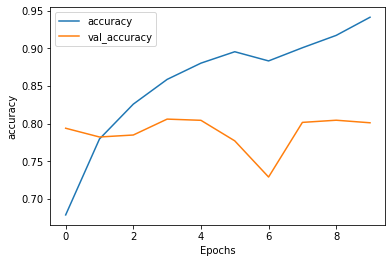

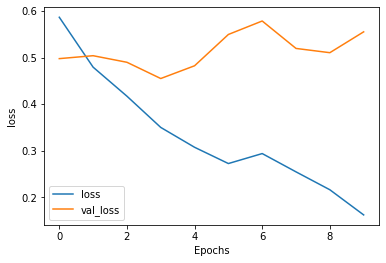

In [8]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history["val_" + string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, "val_" + string])
    plt.show()


# Plot the accuracy and results
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Wrap Up

This lab showed how you can build deep networks by stacking LSTM layers. In the next labs, you will continue exploring other architectures you can use to implement your sentiment classification model.